### Bib Detector 
##### Informatics 4000 Mini-Project #3

An application that leverages deep learning models for vision-based race number detection and gender classification.

*****************************************************************************************************************************

**Datasets used in this application:**

- **'bib-numbers'**- I combined two datasets: [OCR Racing Bib Number Recognition](https://www.kaggle.com/datasets/trainingdatapro/ocr-race-numbers/) and [RBNR](https://people.csail.mit.edu/talidekel/RBNR.html).
- **'gender'** - I used a [dataset downloaded from Kraggle](https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset). 

Both datasets have around a 70/30 split of data between training and testing sets, respectively.

In [2]:
import os
import torch 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
# FILE COUNT FOR 'bib-numbers'

# Parent directory containing the 'bib-numbers' subdirectory
parent_directory = 'datasets'

# List of subdirectories
subdirectories = ['train', 'test']

# Iterate through the subdirectories to count the files
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(parent_directory, 'bib-numbers', subdirectory)
    file_count = sum([len(files) for _, _, files in os.walk(subdirectory_path)])
    print(f"Number of files in '{subdirectory}' directory: {file_count}")

# Calculate the total number of files
total_train_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'train'))])
total_test_files = sum([len(files) for _, _, files in os.walk(os.path.join(parent_directory, 'bib-numbers', 'test'))])

Number of files in 'train' directory: 121
Number of files in 'test' directory: 52


In [5]:
# FILE COUNT FOR 'gender'

# List of categories
categories = ['man', 'woman']

# Iterate through the subdirectories and categories to count the files
for subdirectory in subdirectories:
    print(f"\nSubdirectory: {subdirectory}")
    for category in categories:
        category_path = os.path.join(parent_directory, 'gender', subdirectory, category)
        file_count = sum([len(files) for _, _, files in os.walk(category_path)])
        print(f"{category}: {file_count} files")



Subdirectory: train
man: 12374 files
woman: 6642 files

Subdirectory: test
man: 5304 files
woman: 2847 files


In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image


image 1/1 /Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG: 640x480 6 persons, 1 stop sign, 1 sports ball, 289.0ms
Speed: 6.1ms preprocess, 289.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


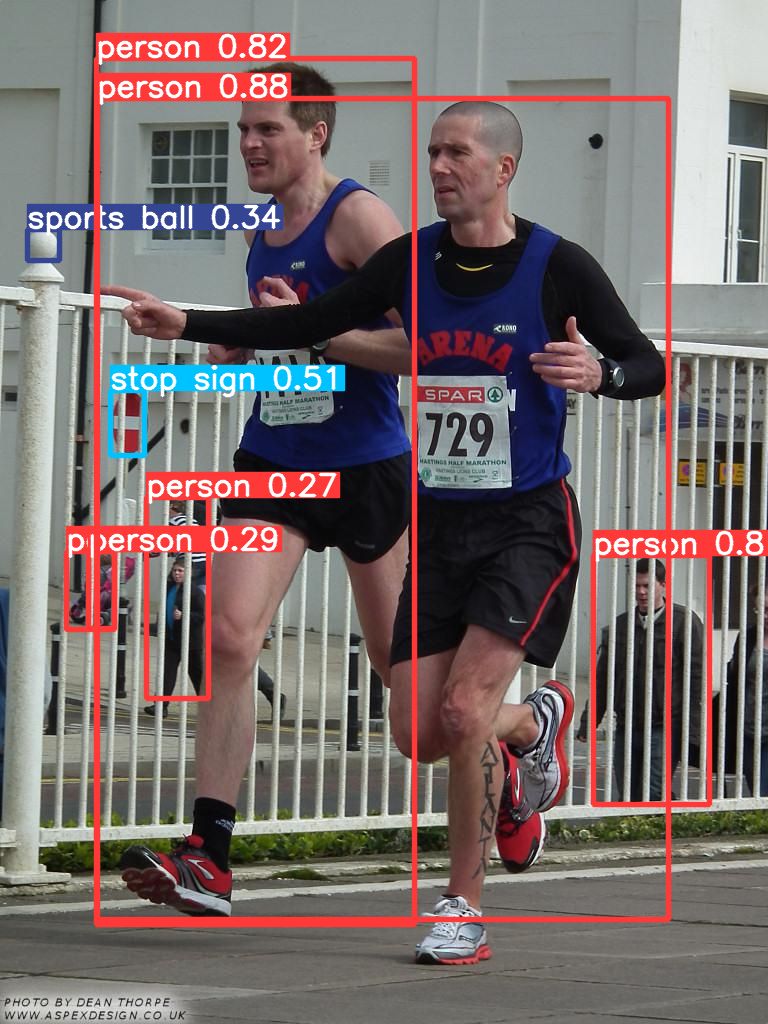

In [7]:
# * The following is modified from an example: *

# Load a pretrained YOLOv8s model
model_people = YOLO('yolov8s.pt') 

# Run inference on 'bus.jpg'
results = model_people('/Users/maddiehope/Desktop/bib-detector/datasets/bib-numbers/test/01.JPG')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    display(im) # show image in output 

As you can see in the image above, YOLOv8s can detect people. Now we have to figure out how to make it detect bibs & numbers within this bibs.

In order to do this, I will need to annotate my training data so that boundary boxes are drawn around the bibs shown in every image. This will help the model learn what exactly a bib is. 

For the next steps of this process, this [guide on Roboflow](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/) was beneficial to me.

The first step is to annotate my training images so that the 'bib' class of objects are clearly boxed in for the model to see and train on. I used the **Roboflow Annotator** to do this.

In [8]:
from roboflow import Roboflow

In [9]:
# Dataset Download Parameters

rf = Roboflow(api_key="yYpsVAGAUqStCCpiXk8k")

project = rf.workspace("university-of-georgia-k4dwo").project("bib-detection-sinjn")

dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Bib-Detection--1 in yolov5pytorch:: 100%|██████████| 355/355 [00:00<00:00, 953.77it/s] 


*****************************************************************************************************************************

**NOTE**: before you can run the code below, you have to go into **'Bib-Detection--1/data.yaml'** and **CHANGE** this line of code: 

##### **val: Bib-Detection--1/valid/images**

changes to:

##### **val:**

There is **NO validation data in this dataset**. I am not sure how to stop the valid section from downloading through Roboflow, so inbewteen running the cell above and the cell below you must manually make this change or you will get an error.

You will probably also have to edit the train and test paths in this file, as they will be different for your computer.

*****************************************************************************************************************************

For reference, here is the text in my 'data.yaml' looks like before the following cell is able to run properly:

In [12]:
'''

names:
- Bib
nc: 1
roboflow:
  license: MIT
  project: bib-detection-sinjn
  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1
  version: 1
  workspace: university-of-georgia-k4dwo
test: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test
train: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train
val:

'''

'\n\nnames:\n- Bib\nnc: 1\nroboflow:\n  license: MIT\n  project: bib-detection-sinjn\n  url: https://universe.roboflow.com/university-of-georgia-k4dwo/bib-detection-sinjn/dataset/1\n  version: 1\n  workspace: university-of-georgia-k4dwo\ntest: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/test\ntrain: /Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/train\nval:\n\n'

Now I can begin the training process through YOLO using my custom dataset:

In [13]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

Ultralytics YOLOv8.0.209 🚀 Python-3.9.18 torch-1.12.1 CPU (Intel Core(TM) i5-8257U 1.40GHz)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/maddiehope/Desktop/bib-detector/Bib-Detection--1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=F

I am not exactly sure why I am getting the error "warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')", becuase the device is specificed to be 'cpu' in one of the very first cells of this notebook.